<a href="https://colab.research.google.com/github/Cutie-tee/Roboreviews_project/blob/main/full_project_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset consists of 3 files: 1429_1.csv
Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv
Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv




In [8]:
!pip install --upgrade pandas


In [9]:
import pandas as pd

def safe_read_csv(file_path):
    """
    Safely reads a CSV file by handling parsing issues.
    """
    try:
        # Read the CSV with specific options for handling errors
        return pd.read_csv(
            file_path,
            on_bad_lines='skip',  # Skips problematic lines
            quotechar='"',       # Specifies the quote character
            escapechar='\\',     # Escapes special characters
            engine='python'      # Use Python engine for better handling of malformed rows
        )
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return None

# Load datasets safely
file1_data = safe_read_csv('1429_1.csv')
file2_data = safe_read_csv('Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv')
file3_data = safe_read_csv('Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

# Check if all files loaded successfully
if file1_data is not None and file2_data is not None and file3_data is not None:
    # Standardizing column names
    file1_data.rename(columns=lambda x: x.strip(), inplace=True)
    file2_data.rename(columns=lambda x: x.strip(), inplace=True)
    file3_data.rename(columns=lambda x: x.strip(), inplace=True)

    # Align datasets to common columns
    common_columns = list(set(file1_data.columns) & set(file2_data.columns) & set(file3_data.columns))

    # Selecting only common columns
    file1_data = file1_data[common_columns]
    file2_data = file2_data[common_columns]
    file3_data = file3_data[common_columns]

    # Concatenate datasets
    combined_data = pd.concat([file1_data, file2_data, file3_data], ignore_index=True)

    # Dropping duplicates
    combined_data.drop_duplicates(inplace=True)

    # Resetting index
    combined_data.reset_index(drop=True, inplace=True)

    # Save cleaned dataset
    combined_data.to_csv('combined_reviews_cleaned.csv', index=False)

    # Display overview
    print("Dataset successfully cleaned and saved.")
    print(combined_data.info())
else:
    print("One or more files could not be loaded.")


Dataset successfully cleaned and saved.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38734 entries, 0 to 38733
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   reviews.text         38733 non-null  object 
 1   id                   38734 non-null  object 
 2   reviews.numHelpful   26090 non-null  float64
 3   reviews.title        38718 non-null  object 
 4   reviews.sourceURLs   38734 non-null  object 
 5   brand                38734 non-null  object 
 6   reviews.id           32 non-null     float64
 7   reviews.doRecommend  26044 non-null  object 
 8   keys                 38734 non-null  object 
 9   reviews.date         38707 non-null  object 
 10  reviews.rating       38702 non-null  float64
 11  name                 38734 non-null  object 
 12  manufacturer         38734 non-null  object 
 13  categories           38734 non-null  object 
 14  reviews.username     38728 non-null  object 
 

In [10]:
# Load the combined dataset
import pandas as pd

# Load the cleaned dataset
combined_data = pd.read_csv('combined_reviews_cleaned.csv')

# Display initial missing values
print("Missing Values Before Processing:")
print(combined_data.isnull().sum())

# 1. Drop rows with missing `reviews.text` (essential for all tasks)
combined_data = combined_data.dropna(subset=['reviews.text'])

# 2. Drop rows with missing `reviews.rating` (essential for classification and clustering)
combined_data = combined_data.dropna(subset=['reviews.rating'])

# 3. Optional: Handle missing values in other columns (example: reviews.doRecommend)
# Here, replace missing values with a default or mode value
combined_data['reviews.doRecommend'] = combined_data['reviews.doRecommend'].fillna('Unknown')

# 4. Drop columns with minimal or irrelevant data (e.g., `reviews.id` with only 71 non-null values)
columns_to_drop = ['reviews.id']
combined_data = combined_data.drop(columns=columns_to_drop, errors='ignore')

# Display missing values after processing
print("\nMissing Values After Processing:")
print(combined_data.isnull().sum())

# Save the preprocessed dataset
preprocessed_dataset_path = 'preprocessed_reviews.csv'
combined_data.to_csv(preprocessed_dataset_path, index=False)

print(f"Preprocessed dataset saved to {preprocessed_dataset_path}.")



Missing Values Before Processing:
reviews.text               1
id                         0
reviews.numHelpful     12644
reviews.title             16
reviews.sourceURLs         0
brand                      0
reviews.id             38702
reviews.doRecommend    12690
keys                       0
reviews.date              27
reviews.rating            32
name                       0
manufacturer               0
categories                 0
reviews.username           6
reviews.dateSeen           0
asins                      2
dtype: int64

Missing Values After Processing:
reviews.text               0
id                         0
reviews.numHelpful     12611
reviews.title             16
reviews.sourceURLs         0
brand                      0
reviews.doRecommend        0
keys                       0
reviews.date              18
reviews.rating             0
name                       0
manufacturer               0
categories                 0
reviews.username           6
reviews.dateSeen    

<ipython-input-10-e3439053492b>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data['reviews.doRecommend'] = combined_data['reviews.doRecommend'].fillna('Unknown')


Preprocessed dataset saved to preprocessed_reviews.csv.


In [11]:
combined_data['reviews.username'] = combined_data['reviews.username'].fillna("Anonymous")
combined_data['name'] = combined_data['name'].fillna("Unknown")

combined_data['reviews.doRecommend'] = combined_data['reviews.doRecommend'].map({'Yes': True, 'No': False})

assert combined_data['reviews.rating'].between(1, 5).all()

combined_data.to_csv('final_preprocessed_reviews.csv', index=False)
print("Final preprocessed dataset saved.")



Final preprocessed dataset saved.


**Sentinent analysis  with RoBerta-base**

In [12]:
!pip install datasets

In [13]:
import pandas as pd

# Load the dataset
data = pd.read_csv('final_preprocessed_reviews.csv', low_memory=False)

# Get the number of rows
num_rows = data.shape[0]

print(f"Number of rows in the dataset: {num_rows}")


Number of rows in the dataset: 38701


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from datasets import Dataset
import torch

# Disable Weights & Biases (W&B) logging
import os
os.environ["WANDB_DISABLED"] = "true"

# Load the final_preprocessed dataset
data = pd.read_csv('final_preprocessed_reviews.csv', low_memory=False)

# Map ratings to sentiment using the given labels
def map_rating_to_sentiment(rating):
    if rating > 3:
        return 2  # Positive
    elif rating == 3:
        return 1  # Neutral
    else:
        return 0  # Negative

data['sentiment'] = data['reviews.rating'].apply(map_rating_to_sentiment)

# Handle class imbalance with oversampling
positive_data = data[data['sentiment'] == 2]
neutral_data = data[data['sentiment'] == 1]
negative_data = data[data['sentiment'] == 0]

# Oversample minority classes to match the Positive class size
neutral_oversampled = resample(neutral_data, replace=True, n_samples=len(positive_data), random_state=42)
negative_oversampled = resample(negative_data, replace=True, n_samples=len(positive_data), random_state=42)

# Combine back into one dataset
balanced_data = pd.concat([positive_data, neutral_oversampled, negative_oversampled])

# Split the balanced data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    balanced_data['reviews.text'], balanced_data['sentiment'], test_size=0.2, random_state=42
)

# Convert to Hugging Face Dataset format
train_df = pd.DataFrame({"text": train_texts, "label": train_labels})
test_df = pd.DataFrame({"text": test_texts, "label": test_labels})

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenizer and model setup
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)  # 3 classes

# Tokenize datasets
def preprocess_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Compute class weights for weighted loss
class_weights = torch.tensor(
    [1.0 / len(negative_data), 1.0 / len(neutral_data), 1.0 / len(positive_data)], dtype=torch.float
).to("cuda" if torch.cuda.is_available() else "cpu")

# Modify the model's loss function to include class weights
from torch.nn import CrossEntropyLoss
model.config.problem_type = "single_label_classification"
model.classifier.weight = class_weights

# Training arguments with epoch-based evaluation, early stopping, and adjusted learning rate
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Evaluate once per epoch
    save_strategy="epoch",        # Save model once per epoch
    learning_rate=1e-5,           # Lower learning rate for better convergence
    per_device_train_batch_size=8,
    num_train_epochs=10,          # Set high epochs; early stopping will stop training earlier
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=2,
    report_to="none",             # Disable W&B and other integrations
    load_best_model_at_end=True,  # Load the best model at the end
    metric_for_best_model="eval_loss",  # Monitor validation loss
    greater_is_better=False       # Smaller loss is better
)

# Define evaluation metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="macro")
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# Define Trainer with EarlyStoppingCallbacktf
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Stop if no improvement for 2 evaluations
)

# Train the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained("./fine_tuned_roberta_sentiment")
tokenizer.save_pretrained("./fine_tuned_roberta_sentiment")

print("Model fine-tuned and saved successfully!")




tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/84216 [00:00<?, ? examples/s]

Map:   0%|          | 0/21054 [00:00<?, ? examples/s]

<ipython-input-14-275cee15637f>:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.083700,0.183984,0.965612,0.967708,0.965691,0.965629
2,0.000800,0.075076,0.985846,0.986306,0.985878,0.985925
3,0.000300,0.088525,0.985703,0.986325,0.985720,0.985777
4,0.000100,0.122197,0.983424,0.984242,0.983438,0.983519


Model fine-tuned and saved successfully!


In [15]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Get predictions on the test dataset
predictions = trainer.predict(test_dataset)

# Extract logits and true labels
logits = predictions.predictions
true_labels = predictions.label_ids

# Convert logits to predicted labels
predicted_labels = np.argmax(logits, axis=1)

# Evaluate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# Generate a classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Negative", "Neutral", "Positive"]))


Accuracy: 0.985845920015199
Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      6878
     Neutral       0.97      1.00      0.98      7147
    Positive       1.00      0.96      0.98      7029

    accuracy                           0.99     21054
   macro avg       0.99      0.99      0.99     21054
weighted avg       0.99      0.99      0.99     21054



In [16]:
#Predict sentiment for new reviews using the fine-tuned model:

from transformers import pipeline

# Load the fine-tuned model
sentiment_classifier = pipeline(
    "text-classification",
    model="./fine_tuned_roberta_sentiment",
    tokenizer="./fine_tuned_roberta_sentiment"
)

# Predict sentiment for a new review
new_review = "This product is amazing! It exceeded all my expectations."
prediction = sentiment_classifier(new_review)
print(prediction)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'LABEL_2', 'score': 0.9999451637268066}]


Clustering with zero classification

In [17]:
from transformers import pipeline
import pandas as pd
import torch
from datasets import Dataset
from tqdm.notebook import tqdm

# Check GPU availability
print("Checking if we have a GPU...")
if torch.cuda.is_available():
    print("Yes! Found GPU!")
    BATCH_SIZE = 8
else:
    print("No GPU found - will be slower")
    BATCH_SIZE = 4

# Set up AI classifier
print("Setting up the AI...")
classifier = pipeline(
    "zero-shot-classification",
    model="cross-encoder/nli-deberta-v3-large",
    device=0 if torch.cuda.is_available() else -1
)

# Product clusters for reviews
categories = [
    "Daily Convenience",
    "Creative and Productivity Tools",
    "Health and Wellness",
    "Entertainment and Immersion",
    "Power and Connectivity Solutions",
    "Eco-Friendly and Sustainable Solutions"
]

# Function to classify reviews
def classify_text(examples):
    try:
        outputs = classifier(
            examples["reviews.text"],
            candidate_labels=categories,
            batch_size=BATCH_SIZE
        )

        # Get the top category for each review
        return {
            "category": [output["labels"][0] for output in outputs]
        }
    except Exception as e:
        print(f"Error processing batch: {str(e)}")
        return {"category": ["Error"] * len(examples["reviews.text"])}

# Process data in chunks (since DeBERTa uses more memory)
print("\nStarting to process reviews...")
chunk_size = 5000  # Process 5000 reviews at a time

for i, chunk_df in enumerate(pd.read_csv('final_preprocessed_reviews.csv', chunksize=chunk_size)):
    print(f"\nProcessing chunk {i+1}")

    # Convert chunk to dataset
    chunk_dataset = Dataset.from_pandas(chunk_df)

    # Process chunk
    classified_chunk = chunk_dataset.map(
        classify_text,
        batched=True,
        batch_size=BATCH_SIZE,
        remove_columns=chunk_dataset.column_names,
        desc=f"Classifying chunk {i+1}"
    )

    # Convert results back to DataFrame
    chunk_results = pd.DataFrame({
        'name': chunk_df['name'],  # Include the 'name' column
        'reviews.text': chunk_df['reviews.text'],
        'category': classified_chunk['category']
    })

    # Save results (append after first chunk)
    chunk_results.to_csv('new_classified_reviews.csv',
                         mode='a' if i > 0 else 'w',
                         header=i == 0,
                         index=False)

    print(f"Finished chunk {i+1}")

    # Clean up GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\nAll done! Check 'new_classified_reviews.csv' for results")

# Show some examples
print("\nHere are some example results:")
try:
    examples = pd.read_csv('new_classified_reviews.csv', nrows=3)
    for i, row in examples.iterrows():
        print(f"\nProduct: {row['name']}")
        print(f"Review {i+1}:")
        print(f"Text: {row['reviews.text'][:100]}...")  # First 100 characters
        print(f"Category: {row['category']}")
except Exception as e:
    print(f"Couldn't read the results file: {e}")

Checking if we have a GPU...
Yes! Found GPU!
Setting up the AI...


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(



Starting to process reviews...

Processing chunk 1


Classifying chunk 1:   0%|          | 0/5000 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Finished chunk 1

Processing chunk 2


Classifying chunk 2:   0%|          | 0/5000 [00:00<?, ? examples/s]

Finished chunk 2

Processing chunk 3


Classifying chunk 3:   0%|          | 0/5000 [00:00<?, ? examples/s]

Finished chunk 3

Processing chunk 4


Classifying chunk 4:   0%|          | 0/5000 [00:00<?, ? examples/s]

Finished chunk 4

Processing chunk 5


Classifying chunk 5:   0%|          | 0/5000 [00:00<?, ? examples/s]

Finished chunk 5

Processing chunk 6


Classifying chunk 6:   0%|          | 0/5000 [00:00<?, ? examples/s]

Finished chunk 6

Processing chunk 7


Classifying chunk 7:   0%|          | 0/5000 [00:00<?, ? examples/s]

Finished chunk 7

Processing chunk 8


Classifying chunk 8:   0%|          | 0/3701 [00:00<?, ? examples/s]

Finished chunk 8

All done! Check 'new_classified_reviews.csv' for results

Here are some example results:

Product: All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta
Review 1:
Text: This product so far has not disappointed. My children love to use it and I like the ability to monit...
Category: Creative and Productivity Tools

Product: All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta
Review 2:
Text: great for beginner or experienced person. Bought as a gift and she loves it...
Category: Entertainment and Immersion

Product: All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta
Review 3:
Text: Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, lear...
Category: Entertainment and Immersion


To validate my model's classification , i will analyse the words that appear more often in each product category

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



Top 10 words for category 'Creative and Productivity Tools':
  great: 1794
  tablet: 1357
  price: 1022
  good: 990
  use: 950
  amazon: 731
  easy: 643
  work: 633
  kindle: 604
  works: 583

Top 10 words for category 'Daily Convenience':
  batteries: 2116
  use: 1607
  great: 1588
  easy: 1309
  good: 989
  price: 950
  tablet: 861
  bought: 702
  amazon: 688
  one: 680

Top 10 words for category 'Eco-Friendly and Sustainable Solutions':
  batteries: 1341
  great: 1086
  good: 985
  price: 831
  long: 433
  product: 410
  bought: 355
  last: 355
  amazon: 354
  well: 327

Top 10 words for category 'Entertainment and Immersion':
  great: 6679
  tablet: 6204
  love: 3790
  kindle: 3368
  use: 3123
  bought: 2883
  price: 2712
  good: 2677
  amazon: 2434
  easy: 2397

Top 10 words for category 'Health and Wellness':
  good: 644
  great: 480
  use: 274
  batteries: 210
  product: 193
  would: 188
  well: 186
  price: 181
  bought: 178
  like: 160

Top 10 words for category 'Power and Co

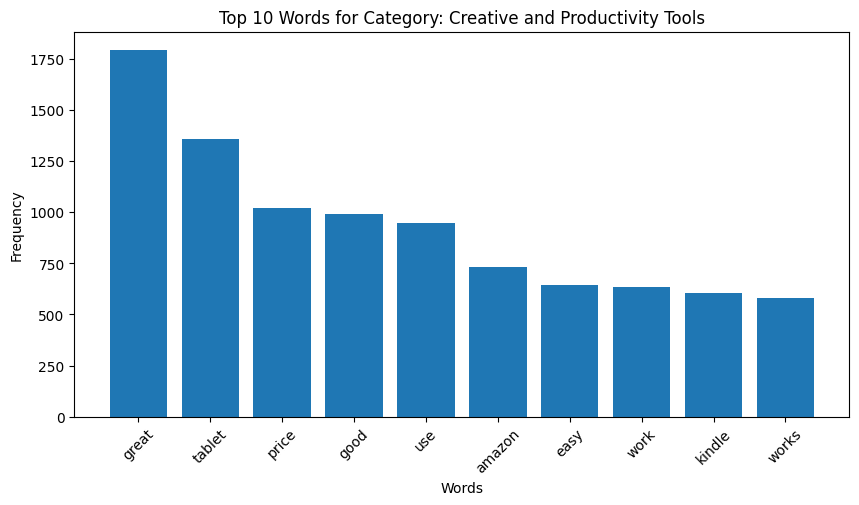

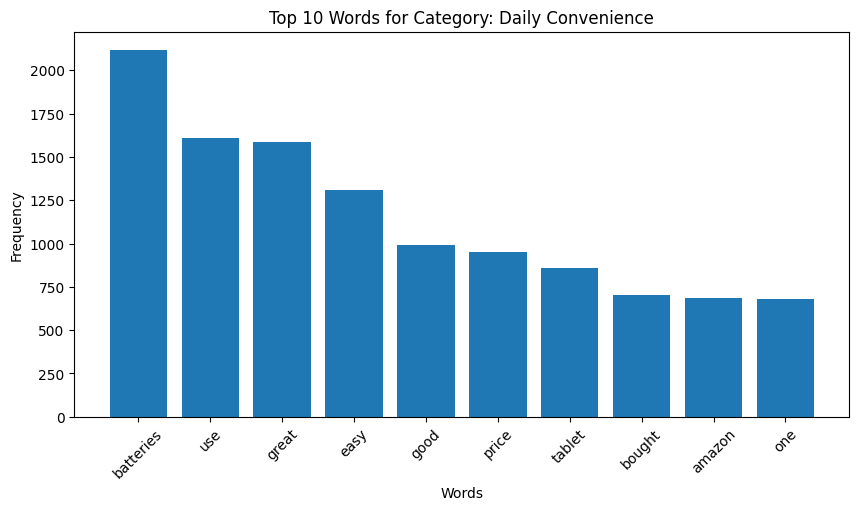

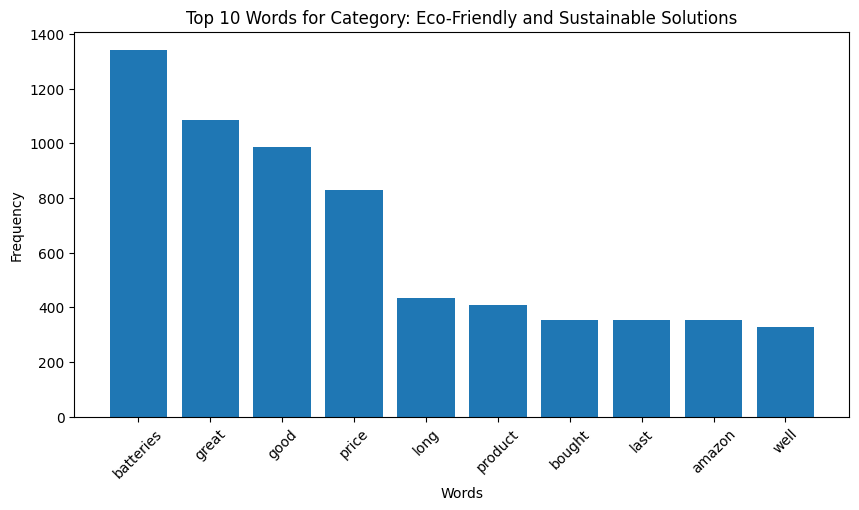

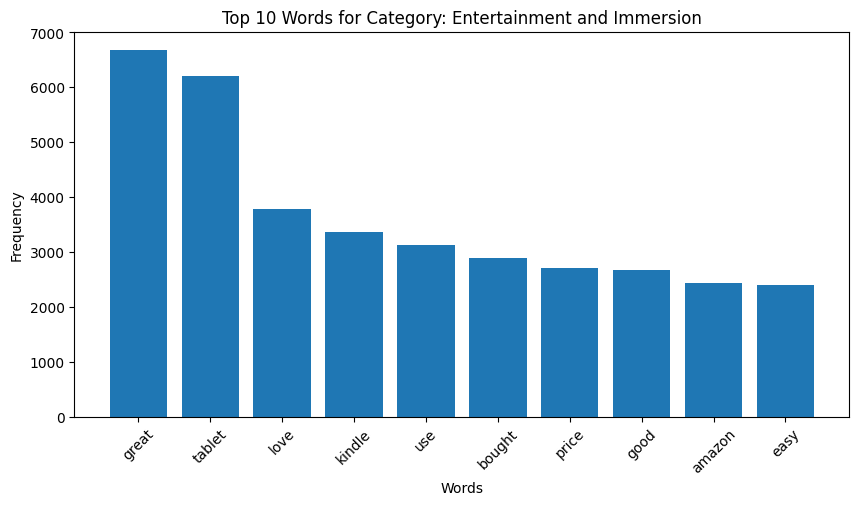

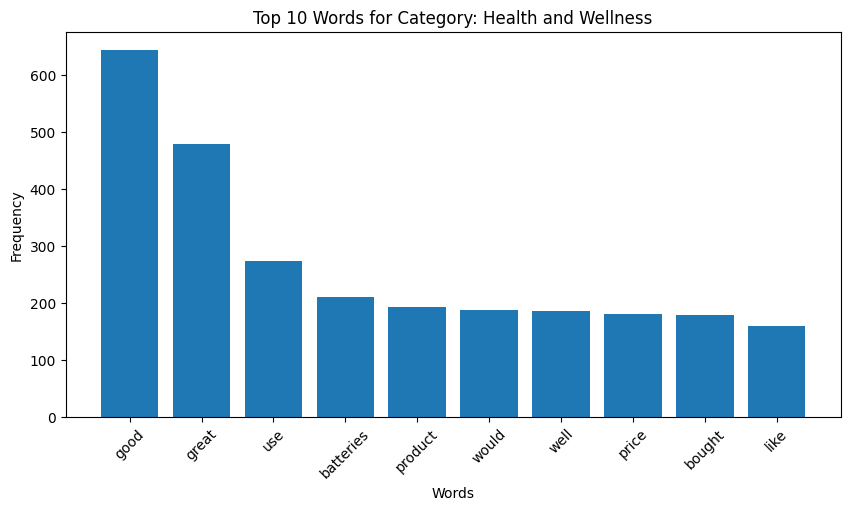

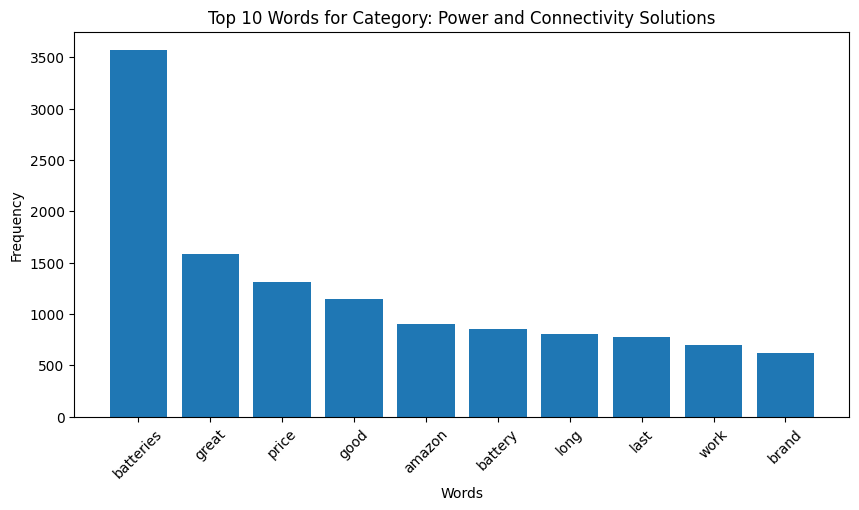

In [18]:
# 1. Load and Group Classified Data
import pandas as pd

# Load the classified data
classified_data = pd.read_csv('new_classified_reviews.csv')

# Group reviews by category
grouped_reviews = classified_data.groupby('category')['reviews.text'].apply(lambda texts: " ".join(texts))

#2. Tokenise and count the words
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

# Ensure stopwords are downloaded
import nltk
nltk.download('stopwords')

# Define the vectorizer with stop words as a list
stop_words = list(set(stopwords.words('english')))  # Convert set to list
vectorizer = CountVectorizer(stop_words=stop_words)

# Create a word frequency matrix for each category
word_counts = {}
for category, text in grouped_reviews.items():
    word_count_matrix = vectorizer.fit_transform([text])
    word_counts[category] = dict(zip(vectorizer.get_feature_names_out(), word_count_matrix.toarray()[0]))


#3 Sort the word frequencies to find the most common words in each category.
# Extract the top N words for each category
top_n = 10  # Top N words to display
top_words_by_category = {
    category: sorted(words.items(), key=lambda item: item[1], reverse=True)[:top_n]
    for category, words in word_counts.items()
}

# Print the results
for category, top_words in top_words_by_category.items():
    print(f"\nTop {top_n} words for category '{category}':")
    for word, freq in top_words:
        print(f"  {word}: {freq}")

#5. Visualize the most frequent words for each category using bar plots.
import matplotlib.pyplot as plt

for category, top_words in top_words_by_category.items():
    words, frequencies = zip(*top_words)
    plt.figure(figsize=(10, 5))
    plt.bar(words, frequencies)
    plt.title(f"Top {top_n} Words for Category: {category}")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()




To identify and remove overlapping words per category, i will To handle overlapping words (words that appear frequently across multiple categories), Filter Out Overlapping Words and set a frequency threshold A word must appear at least k times more in one category than in others to be considered unique.

In [19]:
#Identify Overlapping Words
from collections import defaultdict

# Find top N words for each category
top_n = 10
category_top_words = {
    category: sorted(words.items(), key=lambda item: item[1], reverse=True)[:top_n]
    for category, words in word_counts.items()
}

# Create a dictionary of word occurrences across categories
word_occurrences = defaultdict(list)
for category, top_words in category_top_words.items():
    for word, freq in top_words:
        word_occurrences[word].append((category, freq))

# Find overlapping words
overlapping_words = {word: occurrences for word, occurrences in word_occurrences.items() if len(occurrences) > 1}

# Display overlapping words
print("Overlapping Words Across Categories:")
for word, occurrences in overlapping_words.items():
    print(f"\nWord: '{word}'")
    for category, freq in occurrences:
        print(f"  Category: {category}, Frequency: {freq}")


Overlapping Words Across Categories:

Word: 'great'
  Category: Creative and Productivity Tools, Frequency: 1794
  Category: Daily Convenience, Frequency: 1588
  Category: Eco-Friendly and Sustainable Solutions, Frequency: 1086
  Category: Entertainment and Immersion, Frequency: 6679
  Category: Health and Wellness, Frequency: 480
  Category: Power and Connectivity Solutions, Frequency: 1582

Word: 'tablet'
  Category: Creative and Productivity Tools, Frequency: 1357
  Category: Daily Convenience, Frequency: 861
  Category: Entertainment and Immersion, Frequency: 6204

Word: 'price'
  Category: Creative and Productivity Tools, Frequency: 1022
  Category: Daily Convenience, Frequency: 950
  Category: Eco-Friendly and Sustainable Solutions, Frequency: 831
  Category: Entertainment and Immersion, Frequency: 2712
  Category: Health and Wellness, Frequency: 181
  Category: Power and Connectivity Solutions, Frequency: 1312

Word: 'good'
  Category: Creative and Productivity Tools, Frequency:

allow words that overlap but are disproportionately more frequent in one category, set a frequency ratio threshold

In [20]:
# Define a ratio threshold
overlap_threshold = 2

# Filter overlapping words based on frequency ratio
unique_words = {}
for word, occurrences in overlapping_words.items():
    # Find the maximum frequency and category
    max_category, max_freq = max(occurrences, key=lambda x: x[1])
    total_freq = sum(freq for _, freq in occurrences)

    # If the word is significantly more frequent in one category, keep it
    if max_freq / total_freq > (1 / overlap_threshold):
        unique_words[word] = max_category

# Update filtered word counts to include only unique words
filtered_word_counts_with_threshold = {
    category: {word: freq for word, freq in words.items() if word in unique_words and unique_words[word] == category}
    for category, words in word_counts.items()
}

# Display results
for category, words in filtered_word_counts_with_threshold.items():
    print(f"\nTop Unique Words for Category '{category}':")
    for word, freq in words.items():
        print(f"  {word}: {freq}")


Top Unique Words for Category 'Creative and Productivity Tools':

Top Unique Words for Category 'Daily Convenience':

Top Unique Words for Category 'Eco-Friendly and Sustainable Solutions':
  product: 410
  well: 327

Top Unique Words for Category 'Entertainment and Immersion':
  bought: 2883
  easy: 2397
  great: 6679
  kindle: 3368
  tablet: 6204
  use: 3123

Top Unique Words for Category 'Health and Wellness':

Top Unique Words for Category 'Power and Connectivity Solutions':
  last: 781
  long: 807
  work: 699


In [21]:
from collections import Counter

# Extract top words across all categories
top_words_by_category = {category: [word for word, _ in words] for category, words in filtered_top_words_by_category.items()}

# Calculate overlaps
for cat1, words1 in top_words_by_category.items():
    for cat2, words2 in top_words_by_category.items():
        if cat1 != cat2:
            overlap = set(words1) & set(words2)
            print(f"Overlap between '{cat1}' and '{cat2}': {len(overlap)} words -> {overlap}")

NameError: name 'filtered_top_words_by_category' is not defined

In [ ]:
import pandas as pd
import re
from collections import Counter
from scipy import stats
import nltk

# Download NLTK stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

# Load the stop words and convert them to lowercase
stop_words = set(word.lower() for word in stopwords.words('english'))

# Add custom stop words specific to your dataset
custom_stop_words = {"product", "review", "use", "good", "get"}  # Add more as needed
stop_words = stop_words.union(custom_stop_words)

# Load the classified data
classified_data = pd.read_csv('new_classified_reviews.csv')

# Group reviews by category
grouped_reviews = classified_data.groupby('category')['reviews.text'].apply(lambda texts: " ".join(texts))
grouped_reviews = grouped_reviews.reset_index()

cluster_word_counts = {}

# Process reviews and remove stop words
for index, row in grouped_reviews.iterrows():
    # Tokenize and filter out stop words
    words = re.findall(r'\b\w+\b', row['reviews.text'].lower())
    filtered_words = [word for word in words if word not in stop_words]
    cluster_word_counts[row['category']] = Counter(filtered_words)

# Step 2: Combine all word counts across clusters
all_word_counts = sum((Counter(words) for words in cluster_word_counts.values()), Counter())

# Step 3: Filter terms by minimum frequency
min_count = 5
all_word_counts = {k: v for k, v in all_word_counts.items() if v >= min_count}

if not all_word_counts:
    raise ValueError("No terms meet the minimum frequency threshold.")

# Step 4: Calculate total word count per cluster
cluster_totals = {cluster: sum(counts.values()) for cluster, counts in cluster_word_counts.items()}
total_words = sum(cluster_totals.values())

# Step 5: Calculate expected frequencies under a uniform distribution
expected_freqs = {term: (total_words / len(all_word_counts)) for term in all_word_counts}

# Step 6: Perform Chi-Square analysis for each term in each cluster
results = []
for cluster, word_counts in cluster_word_counts.items():
    cluster_total = cluster_totals[cluster]
    for term, total_observed in all_word_counts.items():
        observed = word_counts.get(term, 0)
        expected = expected_freqs[term] * (cluster_total / total_words)
        chi_square = (observed - expected) ** 2 / expected if expected > 0 else 0
        p_value = 1 - stats.chi2.cdf(chi_square, df=1)
        results.append({
            'cluster': cluster,
            'term': term,
            'observed_freq': observed,
            'expected_freq': expected,
            'chi_square': chi_square,
            'p_value': p_value,
            'significant': p_value < 0.05
        })

# Step 7: Create DataFrame
results_df = pd.DataFrame(results)

# Step 8: Sort results by cluster and chi-square statistic
results_df = results_df.sort_values(['cluster', 'chi_square'], ascending=[True, False])

# Add normalized frequency
results_df['freq_per_1000'] = (results_df['observed_freq'] / total_words) * 1000

results_df

In [ ]:
# prompt: Using dataframe results_df: generate code to filter on true for significant

# Filter the DataFrame to include only rows where 'significant' is True.
significant_results = results_df[results_df['significant'] == True]

# Display the filtered DataFrame (optional).
significant_results

In [ ]:
# prompt: Using dataframe significant_results: generate code to sort by p_value

# Sort the DataFrame by the 'p_value' column in ascending order.
significant_results_sorted = significant_results.sort_values(by='p_value', ascending=True)
# Display the sorted DataFrame.
significant_results_sorted

In [ ]:
# prompt: Using dataframe significant_results_sorted: generate code tosort on p_value

# Sort the DataFrame by the 'p_value' column in ascending order.
significant_results_sorted.sort_values(by='p_value', ascending=True, inplace=True)

In [ ]:
# @title expected_freq

from matplotlib import pyplot as plt
significant_results_sorted_filtered['expected_freq'].plot(kind='hist', bins=20, title='expected_freq')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# @title observed_freq

from matplotlib import pyplot as plt
significant_results_sorted_filtered['observed_freq'].plot(kind='hist', bins=20, title='observed_freq')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Filter for significant terms (p-value < 0.05)
significant_terms = results_df[results_df['significant']]

# Sort by Chi-Square value to see the most significant terms
significant_terms_sorted = significant_terms.sort_values(by='chi_square', ascending=False)

# Display the top significant terms
print("Top Significant Terms by Chi-Square:")
print(significant_terms_sorted[['term', 'cluster', 'chi_square', 'observed_freq', 'expected_freq']].head(10))


In [ ]:
# Inspect terms with the highest observed frequencies
outliers = results_df[results_df['observed_freq'] > 1000]  # Adjust threshold as needed
print("Outliers with High Observed Frequencies:")
print(outliers[['term', 'cluster', 'observed_freq', 'expected_freq']])

In [ ]:
mport matplotlib.pyplot as plt
import numpy as np

# Normalize the frequencies
results_df['expected_freq_normalized'] = results_df['expected_freq'] / results_df['expected_freq'].max()
results_df['observed_freq_normalized'] = results_df['observed_freq'] / results_df['observed_freq'].max()

# Plot normalized frequencies
plt.figure(figsize=(10, 6))
plt.hist(results_df['expected_freq_normalized'], bins=20, alpha=0.5, label='Expected Frequency (Normalized)')
plt.hist(results_df['observed_freq_normalized'], bins=20, alpha=0.5, label='Observed Frequency (Normalized)')
plt.title('Normalized Comparison of Expected and Observed Frequencies')
plt.xlabel('Normalized Frequency')
plt.ylabel('Count')
plt.legend()
plt.show()

In [ ]:
top_significant_terms = significant_terms_sorted.head(10)
print(top_significant_terms[['term', 'cluster', 'chi_square', 'observed_freq', 'expected_freq']])

In [ ]:
plt.figure(figsize=(10, 6))
top_terms = significant_terms_sorted.head(20)
plt.barh(top_terms['term'], top_terms['chi_square'], color='orange')
plt.title('Top 20 Significant Terms by Chi-Square Value')
plt.xlabel('Chi-Square Value')
plt.ylabel('Terms')
plt.gca().invert_yaxis()
plt.show()


Summarizer

Grouping reviews based on categories and sentiment. Ensure sentiment analysis results are stored alongside the categories in your processed dataset.

In [ ]:
import pandas as pd
from transformers import pipeline

# Load the dataset with categories and sentiment
classified_data = pd.read_csv('new_classified_reviews.csv')  # Ensure this file includes sentiment and category columns

# Initialize the summarizer
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Group by category and sentiment
def summarize_reviews(grouped_reviews, sentiment_label):
    """Summarize reviews based on category and sentiment."""
    if grouped_reviews.empty:
        return f"No {sentiment_label} reviews available."

    # Sample 10 reviews for summarization
    sample_reviews = grouped_reviews['reviews.text'].sample(n=min(10, len(grouped_reviews)), random_state=42).tolist()
    combined_text = " ".join(sample_reviews)

    # Generate summary
    try:
        summary = summarizer(
            combined_text,
            max_length=150,  # Maximum length of the summary
            min_length=50,   # Minimum length of the summary
            do_sample=False
        )
        return summary[0]['summary_text']
    except Exception as e:
        return f"Error during summarization: {e}"

# Create business insights
insights = []

for category in classified_data['category'].unique():
    # Filter reviews for the category
    category_reviews = classified_data[classified_data['category'] == category]

    # Positive reviews
    positive_reviews = category_reviews[category_reviews['sentiment'] == 'positive']
    positive_summary = summarize_reviews(positive_reviews, 'positive')

    # Negative reviews
    negative_reviews = category_reviews[category_reviews['sentiment'] == 'negative']
    negative_summary = summarize_reviews(negative_reviews, 'negative')

    # Compile insights
    insights.append({
        "Category": category,
        "Positive Insights": positive_summary,
        "Negative Insights": negative_summary
    })

# Convert insights to a DataFrame for display
insights_df = pd.DataFrame(insights)

# Save insights to a CSV file
insights_df.to_csv("category_sentiment_insights.csv", index=False)

# Display top insights
print(insights_df.head(10))


Testing the model